<a href="https://colab.research.google.com/github/iaanimashaun/DED_Detector/blob/main/ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Tue Apr 27 15:50:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

!pip install -q efficientnet

     |████████████████████████████████| 51kB 4.5MB/s 


In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import efficientnet.tfkeras as efn
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input


In [5]:
import os
from tensorflow.keras.backend import clear_session
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#import optuna

In [6]:
label_data = pd.read_csv('/content/drive/MyDrive/Projects/DED_Detector/DED_Detector_main/retina/trainLabels.csv')

In [7]:
label_data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [8]:
#train_dir = '/content/drive/MyDrive/Hackathon/medhack/gaussian_filtered_images/gaussian_filtered_images/'
train_dir = '/content/drive/MyDrive/Projects/DED_Detector/DED_Detector_main/retina/colored_images/colored_images'

In [10]:
labels = []
values = []
fnames = []
image = []
for level in os.listdir(train_dir):
  level_list = os.listdir(os.path.join(train_dir, level)) 
  #print(level, len(level_list))
  for file in os.listdir(os.path.join(train_dir, level)):
    fnames.append(os.path.join(train_dir, level, file))
    image.append(file.split('.')[0])

  labels.append(level)
  values.append(len(level_list))

In [13]:
print(dict(zip(labels, values)))

{'Severe': 873, 'Moderate': 5292, 'No_DR': 25810, 'Proliferate_DR': 708, 'Mild': 2443}


In [14]:
len(fnames), len(image)

(35126, 35126)

In [15]:
fnames_df = pd.DataFrame({'fnames': fnames, 'image': image})

In [16]:
fnames_df.head()

,fnames,image
0,/content/drive/MyDrive/Projects/DED_Detector/D...,10047_left
1,/content/drive/MyDrive/Projects/DED_Detector/D...,1008_left
2,/content/drive/MyDrive/Projects/DED_Detector/D...,1002_left
3,/content/drive/MyDrive/Projects/DED_Detector/D...,1008_right
4,/content/drive/MyDrive/Projects/DED_Detector/D...,10125_left


In [17]:
new_df = pd.merge(label_data, fnames_df,  how='left', left_on='image', right_on = 'image')

In [18]:
new_df.head()

,image,level,fnames
0,10_left,0,/content/drive/MyDrive/Projects/DED_Detector/D...
1,10_right,0,/content/drive/MyDrive/Projects/DED_Detector/D...
2,13_left,0,/content/drive/MyDrive/Projects/DED_Detector/D...
3,13_right,0,/content/drive/MyDrive/Projects/DED_Detector/D...
4,15_left,1,/content/drive/MyDrive/Projects/DED_Detector/D...


In [19]:
new_df.shape

(35126, 3)

In [49]:
new_df.iloc[0]['fnames']

'/content/drive/MyDrive/Projects/DED_Detector/DED_Detector_main/retina/colored_images/colored_images/No_DR/10_left.png'

In [51]:
values

[873, 5292, 25810, 708, 2443]

In [133]:
#y = new_df['level']
train, test = train_test_split(new_df, test_size=0.1, stratify=new_df['level'])

In [58]:
train.level.value_counts()

0    23229
2     4763
1     2198
3      786
4      637
Name: level, dtype: int64

In [59]:
test.level.value_counts()

0    2581
2     529
1     245
3      87
4      71
Name: level, dtype: int64

In [61]:
train_grouped = train.groupby('level')
new_train = train_grouped.apply(lambda x: x.sample(n=637, replace=False))#.head()
new_train = new_train.set_index('image').reset_index()

In [62]:
new_train['level'].value_counts()#.iloc[0]#['fnames']

3    637
1    637
4    637
2    637
0    637
Name: level, dtype: int64

In [63]:
test_grouped = test.groupby('level')
new_test = test_grouped.apply(lambda x: x.sample(n=300, replace=True))

In [64]:
new_test = new_test.set_index('image').reset_index()#['level'].value_counts()#.iloc[0]#['fnames']

In [65]:
new_test.drop_duplicates(subset=['image'], inplace=True)

In [66]:
new_test['level'].value_counts()#.iloc[0]#['fnames']

0    366
2    282
1    198
3     87
4     70
Name: level, dtype: int64

In [67]:
new_train['level_str'] = new_train['level'].map({0: 'Mild', 1:'Modereate', 2:'Severe',3:'Proliferative', 4:'No_DR'})
new_test['level_str'] = new_test['level'].map({0: 'Mild', 1:'Modereate', 2:'Severe',3:'Proliferative', 4:'No_DR'})

In [68]:
new_test.head()

,image,level,fnames,level_str
0,26955_right,0,/content/drive/MyDrive/Projects/DED_Detector/D...,Mild
1,26939_left,0,/content/drive/MyDrive/Projects/DED_Detector/D...,Mild
2,24416_left,0,/content/drive/MyDrive/Projects/DED_Detector/D...,Mild
3,33936_right,0,/content/drive/MyDrive/Projects/DED_Detector/D...,Mild
4,2243_right,0,/content/drive/MyDrive/Projects/DED_Detector/D...,Mild


In [69]:
new_test.level_str.value_counts()

Mild             366
Severe           282
Modereate        198
Proliferative     87
No_DR             70
Name: level_str, dtype: int64

In [126]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.1,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1#,
                                      #validation_split=0.2
                                  
                                      )
test_datagen = ImageDataGenerator(rescale=1./255)

In [128]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=new_train,
    directory=None, 
    x_col="fnames",
    y_col='level_str',   
    batch_size=32,
    seed=42,
    class_mode='categorical',
    #classes=class_list,
    color_mode = 'rgb',
    target_size=(224,224),
    #subset='training',
     shuffle=True)


val_gen = train_datagen.flow_from_dataframe(
    dataframe=new_train,
    directory=None, 
    x_col="fnames",
    y_col='level_str',
   
    batch_size=32,
    seed=42,
    class_mode='categorical',
    #classes=class_list,
    color_mode = 'rgb',
    target_size=(224,224),
    subset='validation', shuffle=True)

Found 3185 validated image filenames belonging to 5 classes.
Found 0 validated image filenames belonging to 5 classes.


In [129]:
test_gen = datagen.flow_from_dataframe(
    dataframe=new_test,
    directory=None, 
    x_col="fnames",
    y_col='level_str',
    #has_ext=True,
    batch_size=32,
    seed=42,
    class_mode='categorical',
    #classes=class_list,
    color_mode = 'rgb',
    target_size=(224,224))

Found 1003 validated image filenames belonging to 5 classes.


In [81]:
# datagen = ImageDataGenerator(rescale=1./255,
#                                       zoom_range=0.2,
#                                       width_shift_range=0.2,
#                                       height_shift_range=0.2,
#                                       validation_split=0.2
#                                       )
# train_data = datagen.flow_from_directory(train_dir,
#                                                      target_size=(224,224),
#                                                      batch_size=32,
#                                                      class_mode = 'categorical',
#                                                      subset = 'training')

# valid_data = datagen.flow_from_directory( train_dir,
#                                                      target_size=(224,224),
#                                                      batch_size=32,
#                                                      class_mode = 'categorical',
#                                                      subset = 'validation')

Found 28103 images belonging to 5 classes.
Found 7023 images belonging to 5 classes.


Text(0, 0.5, 'Number of images')

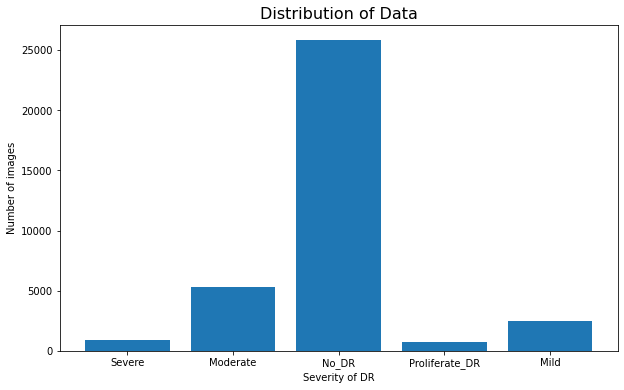

In [73]:
plt.figure(figsize=(10,6))
plt.bar(labels, values)
plt.title('Distribution of Data', fontdict={'fontsize':16})
plt.xlabel('Severity of DR')
plt.ylabel('Number of images')

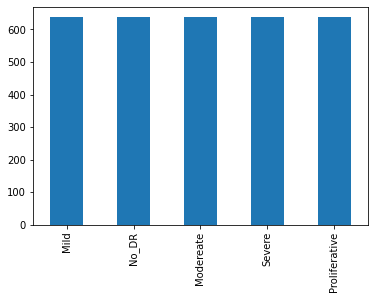

In [76]:
new_train.level_str.value_counts().plot(kind='bar');

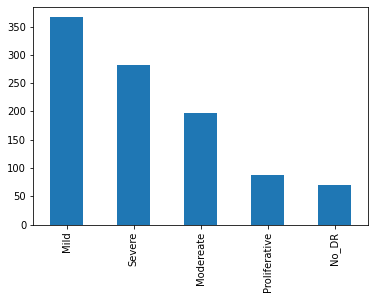

In [77]:
new_test.level_str.value_counts().plot(kind='bar');

Text(0.5, 1.0, 'Proportion of classes in data')

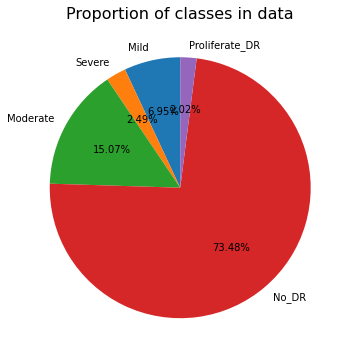

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, startangle=90, autopct=lambda p : '{:.2f}%'.format(p));
plt.title('Proportion of classes in data', fontdict={'fontsize':16})

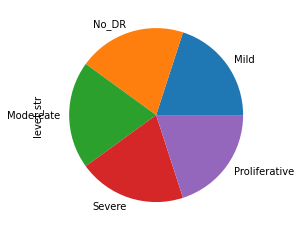

In [78]:
new_train.level_str.value_counts().plot(kind='pie');

In [ ]:
train_fnames = os.listdir( train_dir+'/Mild' )
import matplotlib.pyplot as plt

In [ ]:
image = plt.imread(train_dir + '/Mild/' + train_fnames[0])

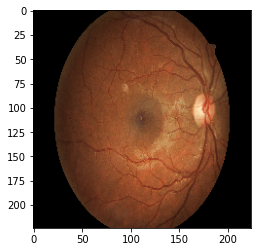

In [ ]:
plt.imshow(image)

In [ ]:
print(train_fnames)


['34350_right.png', '34364_right.png', '34368_left.png', '34382_left.png', '34405_left.png', '34433_left.png', '34433_right.png', '34449_left.png', '34449_right.png', '34454_left.png', '34456_left.png', '34456_right.png', '34551_left.png', '34551_right.png', '34567_left.png', '34567_right.png', '34593_left.png', '34593_right.png', '3459_left.png', '3459_right.png', '34611_right.png', '34644_right.png', '34648_left.png', '34648_right.png', '3464_right.png', '34655_left.png', '34655_right.png', '34696_left.png', '34706_left.png', '34718_left.png', '34718_right.png', '34734_right.png', '34757_left.png', '34761_right.png', '34814_left.png', '34841_right.png', '34862_right.png', '348_left.png', '348_right.png', '34905_right.png', '34990_left.png', '34992_left.png', '35010_right.png', '35054_left.png', '35054_right.png', '35057_right.png', '35064_left.png', '35064_right.png', '35090_left.png', '35095_left.png', '35095_right.png', '3515_left.png', '35183_right.png', '35205_left.png', '35215_l

In [ ]:
#os.removedirs(train_dir+'/.ipynb_checkpoints')

In [79]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=3)

In [135]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.001
        return lr
    elif epoch<=15:
        lr=0.005
        return lr
    elif epoch<=30:
        lr=0.001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo


weight_path="{}_model.best.hdf5".format('efn')
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'loss', 
                      mode= 'auto', 
                      patience=10)

callbacks_list = [checkpoint, early, lr_callback]

In [104]:
model = tf.keras.Sequential([
        efn.EfficientNetB0(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(5, activation='softmax')
    ])

    
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [105]:
weight_path="{}_model.best.hdf5".format('efn')
efn_history=model.fit(train_gen,validation_data = val_gen,callbacks=callbacks_list,epochs=3,verbose=1)

Epoch 1/3
44/80 [===============>..............] - ETA: 17s - loss: 2.6289 - accuracy: 0.2444

KeyboardInterrupt: ignored

In [106]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model

In [115]:
def build_my_model():
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    vgg_base = load_pretrained_model()
    my_model.add(vgg_base)
    my_model.add(Flatten())
    

    # my_model.add(Dense(1024, activation='relu'))
    # my_model.add(Dropout(0.5))
    #model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.25))
    #model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.25))
    #model.add(BatchNormalization())
    #model.add(Dense(num_classes, activation='softmax'))
    my_model.add(Dense(5, activation='softmax'))
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    my_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # Todo
    
    return my_model


In [116]:
my_model = build_my_model()

In [118]:
weight_path="{}_model.best.hdf5".format('ded_vgg')
vgg_history = my_model.fit(train_gen, 
                          validation_data = val_gen, 
                          epochs = 3, 
                         callbacks = callbacks_list)

Epoch 1/3
80/80 [==============================] - 42s 515ms/step - loss: 1362.5483 - accuracy: 0.2522 - val_loss: 5.0257 - val_accuracy: 0.0000e+00

Epoch 00001: loss did not improve from 1.87144
Epoch 2/3
80/80 [==============================] - 41s 507ms/step - loss: 1.4815 - accuracy: 0.2293 - val_loss: 5.9615 - val_accuracy: 0.0000e+00

Epoch 00002: loss improved from 1.87144 to 1.60939, saving model to efn_model.best.hdf5
Epoch 3/3
80/80 [==============================] - 41s 509ms/step - loss: 1.4497 - accuracy: 0.2509 - val_loss: 7.7835 - val_accuracy: 0.0000e+00

Epoch 00003: loss did not improve from 1.60939


In [147]:
val.level.value_counts()

0    2581
2     529
1     245
3      87
4      71
Name: level, dtype: int64

In [120]:
num_classes = 5

In [130]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
# model.add(UpSampling2D())
# model.add(UpSampling2D())
# model.add(UpSampling2D())
model.add(resnet_model)
#model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [134]:
weight_path="{}_model.best.hdf5".format('ded_resnet')
history = model.fit(train_gen, epochs=100, validation_data=test_gen)#, callbacks=callbacks_list)

Epoch 1/5
100/100 [==============================] - 46s 460ms/step - loss: 1.7117 - accuracy: 0.2465
Epoch 2/5
100/100 [==============================] - 46s 458ms/step - loss: 1.6785 - accuracy: 0.2524
Epoch 3/5
 38/100 [==========>...................] - ETA: 28s - loss: 1.6811 - accuracy: 0.2229

KeyboardInterrupt: ignored

In [28]:
def display_training_curves(training, validation, title, subplot):
    
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('EfficientNet '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

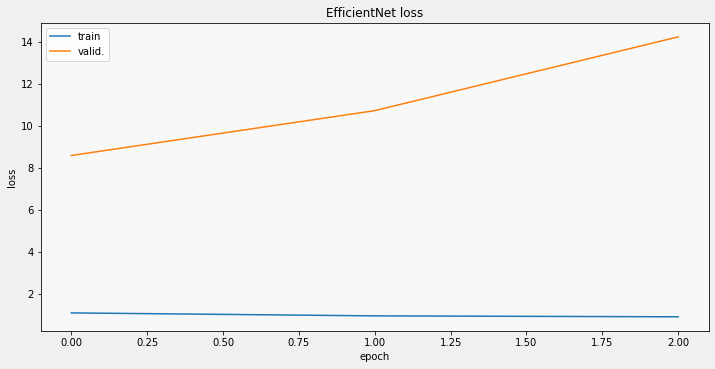

In [29]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)


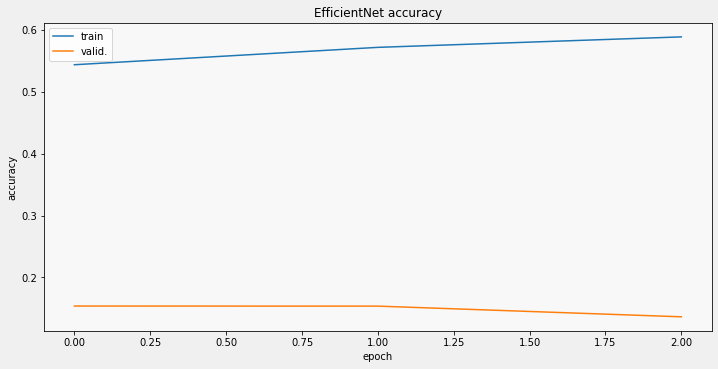

In [30]:
display_training_curves(
    history.history['acc'], 
    history.history['val_acc'], 
    'accuracy', 211)

In [ ]:
model.save("/content/drive/MyDrive/Hackathon/medhack/model")
print("Saved model to disk")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Hackathon/medhack/model/assets
Saved model to disk


In [ ]:
#model.save() or tf.keras.models.save_model()

In [ ]:
loaded = tf.keras.models.load_model("model")

In [ ]:
loaded

In [ ]:
['Mild', 'Severe', 'Moderate', 'Proliferate_DR', 'No_DR']

['Mild', 'Severe', 'Moderate', 'Proliferate_DR', 'No_DR']

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 path='/content/' + fn
  # predicting images
def predict_class(path)
  
  img=image.load_img(path, target_size=(224, 224))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  class = ''
  for idx, i in enumerate(classes.squeeze()):
    if i == 1.0:
      predicted_class += labels[idx]
      #print(classes)


  return predicted_class
  
  
  

Saving dr2.jfif to dr2 (12).jfif
2 1.0
Moderate


In [ ]:
pip install -q pyyaml h5py

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.4.1


In [ ]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
loaded.save('model.h5')

In [ ]:
new_model = tf.keras.models.load_model('model.h5')

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fpr, tpr, _ = metrics.roc_curve(t_y,  p_y)
    auc = metrics.roc_auc_score(t_y, p_y)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    # Todo
    
    return

In [ ]:
print(metrics.classification_report(valY, p))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = train_gen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(valY, p, class_names, ax1, title="Custom CNN")    
#plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG16) No Fine-Tuning")    
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
!pip install plot_keras_history

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(vgg_history.history)
plt.show()
plot_history(vgg_history.history, path="standard.png")
plt.close()

In [ ]:
print(vgg_history.history.keys())
# summarize history for accuracy
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
YOUR_THRESHOLD = 0.5

In [ ]:
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if p[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if p[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1